# Drifter L2 scipy filter analysis
- implement each filter for a ndarray
- plot PSD of each filter : gaussian, wavelet, low pass complex

In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *
from utils_plots import welch
import Drifters_processing

import scipy
import scipy.signal

import numpy as np

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

drifters_directory = '/home/bouxdecl/Documents/data/DRIFTERS'
path_save_plot = '/home/bouxdecl/Documents/MEOM_internship_2024/save_plots/save_plots_2024-06-25_DrifterL2_filter_variance_analysis'

#### drifters data

In [2]:
L2_dir = drifters_directory + '/L2'
FILES_SVP

['L2_svp_scripps_10min_lowess_30min_v0.nc',
 'L2_svp_ogs_1h_lowess_30min_v0.nc',
 'L2_svp_ogs_10min_lowess_30min_v0.nc',
 'L2_svp_shom_10min_lowess_30min_v0.nc',
 'L2_svp_scripps_1h_lowess_30min_v0.nc',
 'L2_svp_bcg_10min_lowess_30min_v0.nc']

## One trajectory filtering

In [3]:
file = FILES_SVP[3]
id_idx = 7

ds = xr.open_dataset(os.path.join(L2_dir, file))
ds_traj = ds.isel(id=id_idx)

#time resolution in seconds
dt = float(ds_traj.time[1] - ds_traj.time[0])*1e-9

ds_traj

<xarray.Dataset>
Dimensions:     (time: 9024)
Coordinates:
    id          <U15 '300534060114360'
  * time        (time) datetime64[ns] 2023-03-31T14:30:00 ... 2023-10-05T14:0...
Data variables: (12/26)
    u           (time) float64 ...
    v           (time) float64 ...
    x           (time) float64 ...
    y           (time) float64 ...
    platform    <U11 ...
    lonc        float64 ...
    ...          ...
    start_lon   float64 ...
    start_lat   float64 ...
    end_time    datetime64[ns] ...
    end_lon     float64 ...
    end_lat     float64 ...
    end_reason  <U10 ...
Attributes: (12/15)
    description:                     L2 product - applied smoothing method on...
    drifter_type:                    SVP
    laboratory:                      SHOM
    campaign:                        CSWOT-WEMSWOT
    campaign_doi:                    https://doi.org/10.17600/18002077
    raw_download_max_date:           2023-10-05 14:00:00
    ...                              ...
    interpolation_sampling:          30min
    nominal_raw_sampling:            10min
    geographical_projection:         Asimuthal Equidistant projection centere...
    geographical_projection_pyproj:  pyproj.Proj(proj="aeqd", lat_0=latc, lon...
    smoothing_method:                LOWESS
    smoothing_method_param_dict:     {'degree': 2, 'iteration': 3, 'T_low_pas...

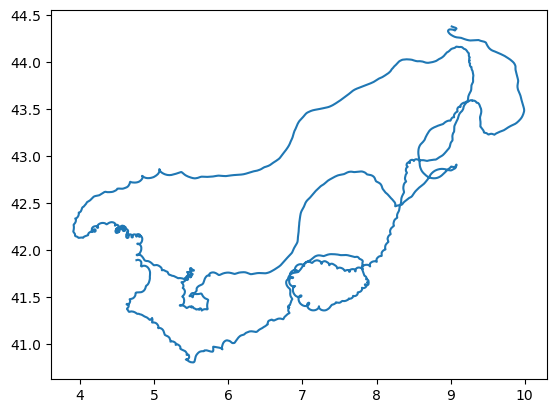

In [4]:
plt.plot(ds_traj.lon.values, ds_traj.lat.values)

/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


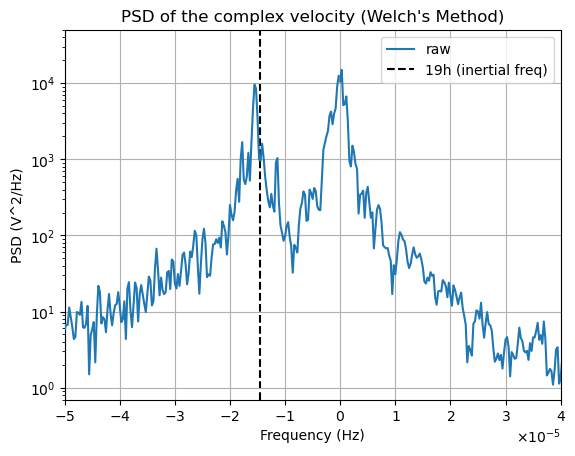

In [5]:
sig_raw = ds_traj['u'] + 1j* ds_traj['v']
sig_raw = sig_raw[~np.isnan(sig_raw)]
_ = welch([sig_raw], ['raw'], dt, nfenetre=2000, save=False)

## Variance Analysis for the scipy filter

In [6]:
#signal filtering
dt = float(ds_traj.time[1] - ds_traj.time[0])*1e-9

sig_filtered = Drifters_processing.low_pass_complex(sig_raw, dt, cutoff=1/(48*3600), order=8)

/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


filtering at 19h: 1.257349082583495e-09
filtering at 24h: 1.4937479548248681e-09
filtering at 36h: 0.00018486953031450191
filtering at 48h: 0.3203568288693662
filtering at 72h: 0.9970997877252972
filtering at 96h: 0.9998923500158956
filtering at 120h: 1.0000045785025042


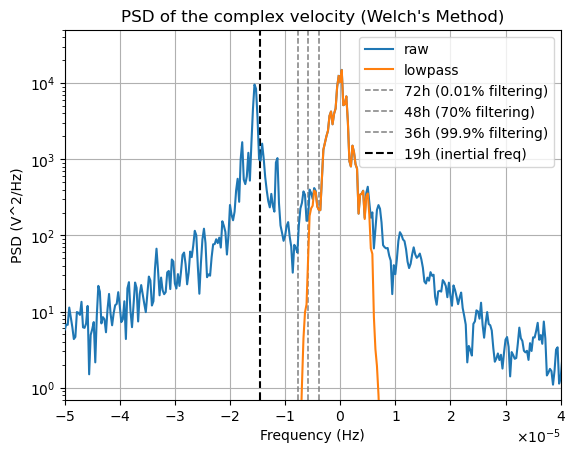

In [7]:
#plot PSD
(freq0, psd0), (freq, psd) = welch([sig_raw, sig_filtered], ['raw', 'lowpass'], dt, [(72, '72h (0.01% filtering)', 'grey'),
                                                                                      (48, '48h (70% filtering)', 'grey'),
                                                                                      (36, '36h (99.9% filtering)', 'grey')
                                                                                      ], 
                                                                                      nfenetre=2000, save=True, save_path=path_save_plot)

ord = np.argsort(freq) 

freq = freq[ord]
psd = psd[ord]
psd0 = psd0[ord]

filter_fraction = psd/psd0

# filtering at 19h
print('filtering at 19h:', np.interp(1/(19*3600), freq, filter_fraction))
print('filtering at 24h:', np.interp(-1/(24*3600), freq, filter_fraction))
print('filtering at 36h:', np.interp(-1/(36*3600), freq, filter_fraction))
print('filtering at 48h:', np.interp(-1/(48*3600), freq, filter_fraction))
print('filtering at 72h:', np.interp(-1/(72*3600), freq, filter_fraction))
print('filtering at 96h:', np.interp(-1/(96*3600), freq, filter_fraction))
print('filtering at 120h:', np.interp(-1/(120*3600), freq, filter_fraction))

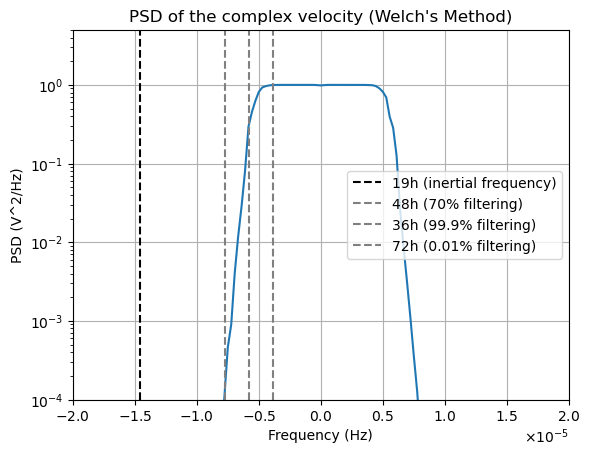

In [8]:
fig, ax = plt.subplots()

ax.semilogy(freq, filter_fraction)

ax.axvline(-1/(19*3600), c='black', ls='--', label='19h (inertial frequency)')
ax.axvline(-1/(48*3600), c='grey', ls='--', label='48h (70% filtering)')
ax.axvline(-1/(36*3600), c='grey', ls='--', label='36h (99.9% filtering)')
ax.axvline(-1/(72*3600), c='grey', ls='--', label='72h (0.01% filtering)')

xlim = 2e-5
ax.set_xlim(-xlim, xlim)
ax.set_ylim(1e-4, 5)

ax.set_title('PSD of the complex velocity (Welch\'s Method)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (V^2/Hz)')
ax.grid()
ax.legend()

# Set the x-axis to display in powers of ten
formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))
ax.xaxis.set_major_formatter(formatter)

plt.savefig(os.path.join(path_save_plot, 'ratio_psd.png'), bbox_inches='tight', dpi = 300)

**Variance preserving**

not equal ??

In [9]:
df = freq[1] - freq[0]
scipy.integrate.simpson(psd, dx=df)

0.029670982332308703

In [11]:
np.var(sig_raw)

<xarray.DataArray ()>
array(0.05348549)
Coordinates:
    id       <U15 '300534060114360'

## trajectory scheme reconstuction
- use the process LOWESS used to find the L2 velocities in order to reconstruct the filtered position from the filtered velocity

-> not possible because LOWESS method is not analytic (inversion is not easy)